# Gendist V1.0

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from augly import image
from sklearn.decomposition import PCA
from datetime import datetime
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [3]:
from tqdm.notebook import tqdm

In [4]:
import gendist
from gendist import training, processing

In [5]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params
from gendist.training import TrainingConfig, make_cross_entropy_loss_func

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [8]:
n_classes = 10
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [9]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 150
alpha = 0.001
tx = optax.adam(learning_rate=alpha)

In [10]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

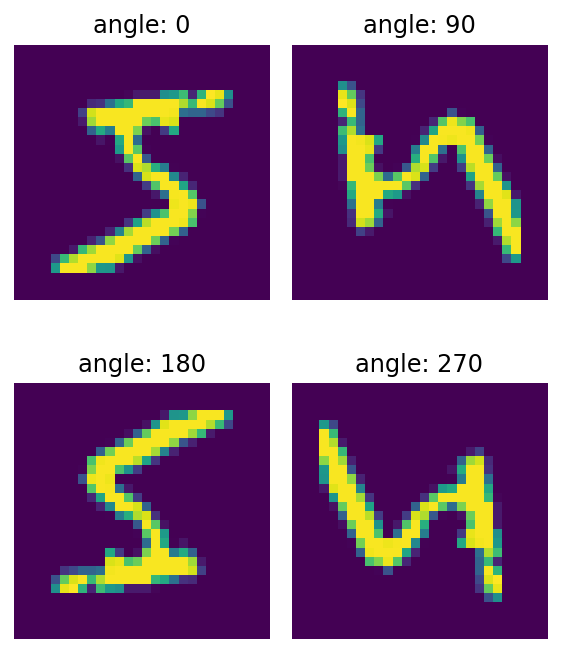

In [11]:
degrees = [0, 90, 180, 270]

fig, ax = plt.subplots(2, 2, figsize=(4, 5))
for axi, deg in zip(ax.flat, degrees):
    x_shift = processor(X_train[0], deg)
    
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"angle: {deg}")
plt.tight_layout()

In [12]:
proc_class = gendist.processing.Factory(processor)

model = MLPDataV1(n_classes)
degrees = np.r_[np.linspace(0, 90, 50), np.linspace(180, 270, 50)]

In [ ]:
train_config = TrainingConfig(model, proc_class, make_cross_entropy_loss_func, tx)
configs_params = []
configs_accuracy = []
for deg in tqdm(degrees):
    config = {"angle": float(deg)}
    params, train_acc = train_config.train_model_config(key, X_train, y_train_ohe,
                                                        config, n_epochs, batch_size)
    configs_params.append(params)
    configs_accuracy.append(train_acc)

In [79]:
date_str = datetime.now().strftime("%y%m%d")
filename = f"mnist-rotate-trenches-params-{date_str}.pkl"
output_elements = {
    "configs": radii,
    "params": configs_params,
    "metric": configs_accuracy
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [14]:
configs_params_flat, fn_recontruct_params = dojax.flat_and_concat_params(configs_params)

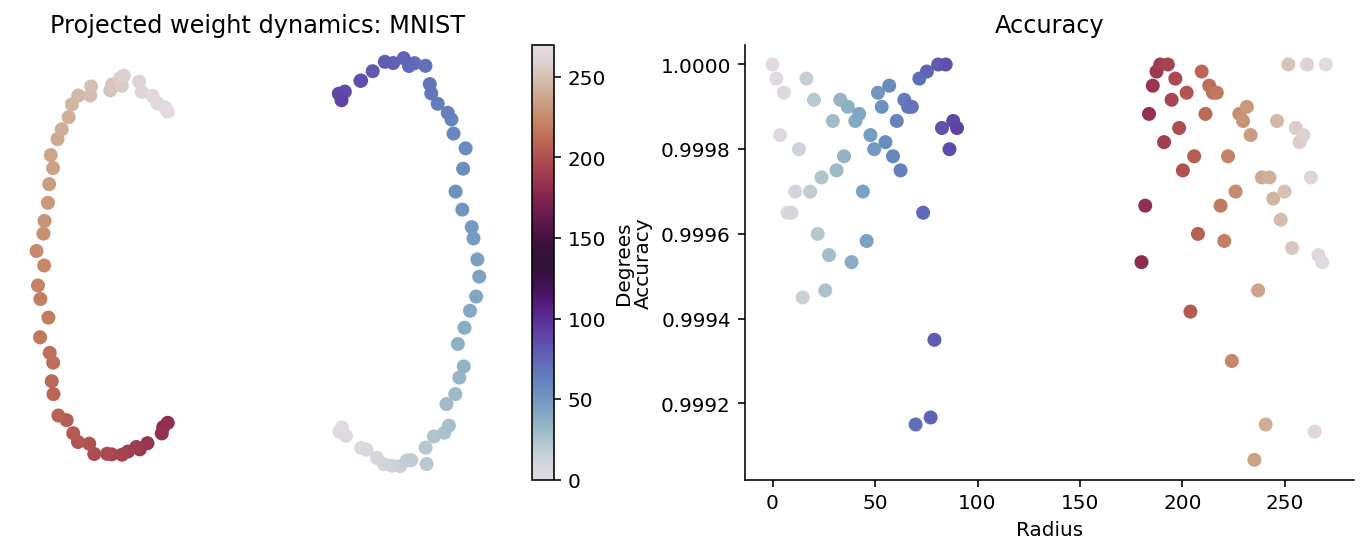

In [137]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
im =  ax[0].scatter(*params_proj.T, c=degrees, cmap="twilight")
fig.colorbar(im, ax=ax[0], label="Degrees")

ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")
ax[0].axis("off")


ax[1].set_title("Accuracy")
ax[1].scatter(degrees, configs_accuracy, c=degrees, cmap="twilight")
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy");

## Training weights

In [138]:
configs_params_flat.shape

(100, 1033510)

In [147]:
n_components = 30
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

In [148]:
angle_dict = [{"angle": float(deg)} for deg in degrees]

In [149]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [150]:
logger.remove()

In [102]:
logger.add("training-weights-rotation-trench-n100.log", rotation="5mb")
logger.warning("Initialising process")

In [103]:
alpha = 0.0001
tx = optax.adam(learning_rate=alpha)

weights_model = gendist.models.MLPWeightsV1(n_components)
train_config = gendist.training.TrainingShift(weights_model, proc_class,
                                              gendist.training.make_multi_output_loss_func,
                                              tx)

In [151]:
weigths_trained = None

In [105]:
batch_size = 10_000
num_epochs = 5
weights_trained, losses = train_config.train(key, X_train[subset_ix], params_proj,
                                             angle_dict, batch_size, num_epochs, logger, weigths_trained)

https://symbolize.stripped_domain/r/?trace=556ece8c1ee9,7f1dad2413bf,556eceb1173f&map= 
*** SIGTERM received by PID 1482575 (TID 1482575) on cpu 7 from PID 1424425; stack trace: ***
PC: @     0x556ece8c1ee9  (unknown)  _PyObject_GetMethod
    @     0x7f1d9caef7fa        992  (unknown)
    @     0x7f1dad2413c0  (unknown)  (unknown)
    @     0x556eceb11740  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=556ece8c1ee9,7f1d9caef7f9,7f1dad2413bf,556eceb1173f&map=7a511a57244151c993b16b37978e7ed7:7f1d8e117000-7f1d9ce59d50 
E0311 15:28:15.831138 1482575 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0311 15:28:15.860487 1482575 process_state.cc:770] RAW: Raising signal 15 with default behavior


In [106]:
with open("weights-dynamics-rotation-trench-v2.params", "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [21]:
angle_test = np.linspace(0, 360, 100)

In [23]:
with open(observed_space_filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [24]:
with open("weights-dynamics-rotation-trench.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [108]:
logger.remove()
test_filename = "projection-accuracy-rotation-trenches-v1.2.log"
logger.add(test_filename, rotation="5mb")

3

In [109]:
X_test = np.array(mnist_test.data)
y_test = np.array(mnist_test.targets)

In [ ]:
ix = 0
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    angle = float(angle)
    x_test_shift = proc_class.process_single(X_test[ix], angle=angle)
    predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
    reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
    reconstructed_predicted_weights = fn_recontruct_params(reconstructed_predicted_weights)
    
    X_test_shift_ravel = proc_class(X_test, {"angle": angle})
    y_test_hat = model.apply(reconstructed_predicted_weights, X_test_shift_ravel)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned)
    
    predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

We evaluate the predicted weights on the training dataset

In [124]:
test_filename = "projection-accuracy-rotation-trenches-v1.2-on-train.log"
logger.add(test_filename, rotation="5mb")

4

In [125]:
ix = 0
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    angle = float(angle)
    x_test_shift = proc_class.process_single(X_train[ix], angle=angle)
    predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
    reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
    reconstructed_predicted_weights = fn_recontruct_params(reconstructed_predicted_weights)
    
    X_test_shift_ravel = proc_class(X_train[:10_000], {"angle": angle})
    y_test_hat = model.apply(reconstructed_predicted_weights, X_test_shift_ravel)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_train[:10_000]).mean()
    accuracy_configs_learned.append(accuracy_learned)
    
    predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=7f1dad23f3f4,7f1dad2413bf,7f&map= 
*** SIGTERM received by PID 1542207 (TID 1542207) on cpu 95 from PID 1424425; stack trace: ***
PC: @     0x7f1dad23f3f4  (unknown)  do_futex_wait.constprop.0
    @     0x7f1d9caef7fa        992  (unknown)
    @     0x7f1dad2413c0  376204432  (unknown)
    @               0x80  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=7f1dad23f3f4,7f1d9caef7f9,7f1dad2413bf,7f&map=7a511a57244151c993b16b37978e7ed7:7f1d8e117000-7f1d9ce59d50 
E0313 10:49:21.463888 1542207 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0313 10:49:21.495246 1542207 process_state.cc:770] RAW: Raising signal 15 with default behavior


In [128]:
predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)

Text(0.5, 1.0, 'One-shot weight-prediction')

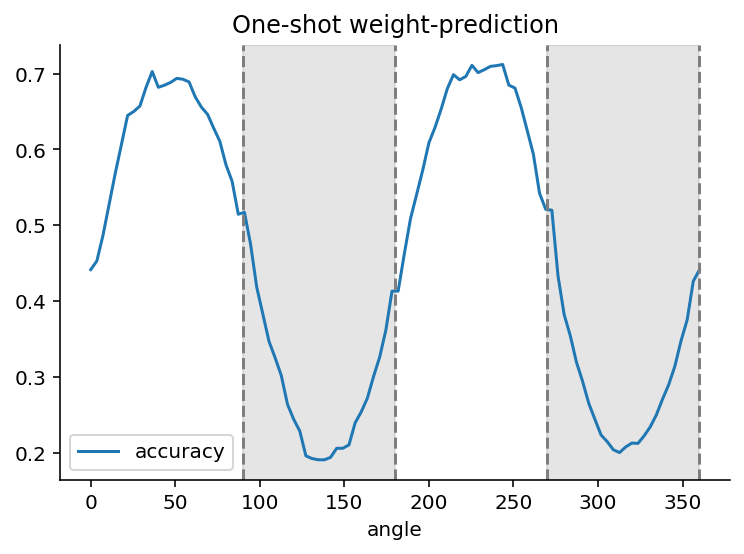

In [130]:
import re
with open(test_filename, "r") as f:
    logs = f.read()
    
regexp = re.compile(r"angle=([0-9\.]+) \| accuracy_learned=([0-9\.]+)")

log_vals = []
for line in logs.split("\n")[:-1]:
    rad = regexp.search(line)[1]
    acc = regexp.search(line)[2]
    log_vals.append({"angle": float(rad), "accuracy": float(acc)})

log_df = pd.DataFrame(log_vals).set_index("angle")
log_df.plot()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.axvspan(90, 180, alpha=0.2, color="tab:gray")

plt.axvline(x=270, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.axvspan(270, 360, alpha=0.2, color="tab:gray")

plt.title("One-shot weight-prediction")

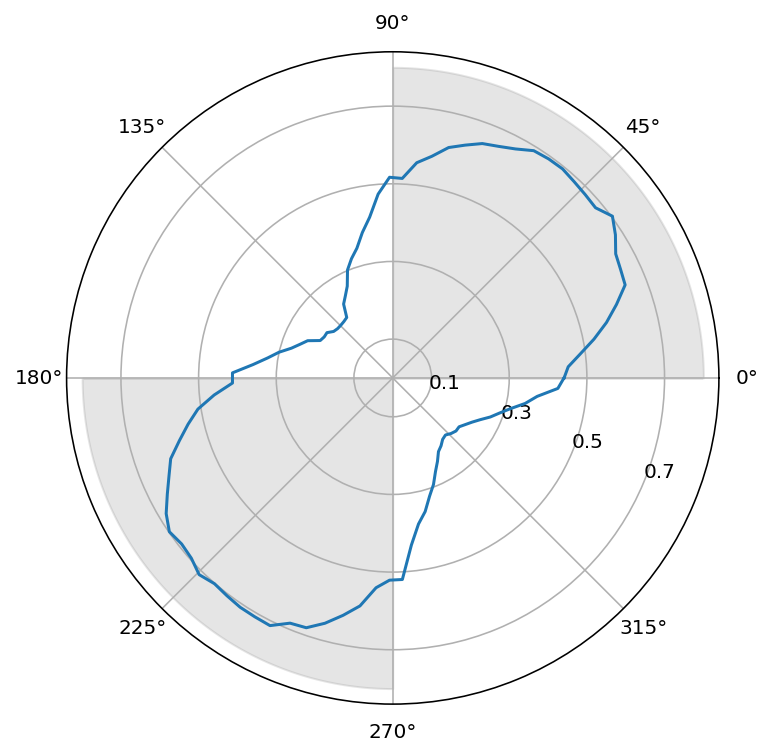

In [132]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
rad = log_df.index.values * np.pi / 180
ax.plot(rad, log_df["accuracy"])
ax.set_rticks([0.1, 0.3, 0.5, 0.7])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.fill_between(np.linspace(0, np.pi/2, 100), 0, 0.8, alpha=0.2, color="tab:gray")
ax.fill_between(np.linspace(np.pi, 3 * np.pi/2, 100), 0, 0.8, alpha=0.2, color="tab:gray")

ax.grid(True)

All the weights are predicting the same value

In [118]:
np.r_[predicted_weights_array][:, 0]

array([ 0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277, -0.07790521,
       -0.07790521,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00380277,
        0.00380277,  0.00380277,  0.00380277,  0.00380277,  0.00

In [119]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [ ]:
pca_reconstruct = TSNE(n_components=2, perplexity=15, random_state=314)
pca_reconstruct = PCA(n_components=2)
predicted_matrix = np.r_[predicted_weights_array]

colors = ["tab:red" if 1 < radius < 2 else "tab:blue" for radius in angle_test]
plt.scatter(*pca_reconstruct.fit_transform(predicted_matrix).T, c=colors)
plt.colorbar()